In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import os
import pickle
import argparse
import time
import torch
import torch.nn as nn
# import torch.backends.cudnn as cudnn
import torchvision.transforms as trn
import torchvision.datasets as dset
import torch.nn.functional as F
from tqdm.notebook import tqdm

import sys
sys.argv = ['']

parser = argparse.ArgumentParser(description='Tunes a CIFAR Classifier with OE',
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--dataset', type=str, choices=['cifar10', 'cifar100'], default='cifar10',
                    help='Choose between CIFAR-10, CIFAR-100.')
parser.add_argument('--model', '-m', type=str, default='resnet18',
                    choices=['resnet18', 'resnet50'], help='Choose architecture.')
# parser.add_argument('--calibration', '-c', action='store_true',
#                     help='Train a model to be used for calibration. This holds out some data for validation.')
# Optimization options
parser.add_argument('--epochs', '-e', type=int, default=10, help='Number of epochs to train.')
parser.add_argument('--learning_rate', '-lr', type=float, default=0.001, help='The initial learning rate.')
parser.add_argument('--batch_size', '-b', type=int, default=128, help='Batch size.')
parser.add_argument('--oe_batch_size', type=int, default=256, help='Batch size.')
parser.add_argument('--test_bs', type=int, default=200)
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum.')
parser.add_argument('--decay', '-d', type=float, default=0.0005, help='Weight decay (L2 penalty).')
# Checkpoints
parser.add_argument('--save', '-s', type=str, default='./snapshots/oe_scratch', help='Folder to save checkpoints.')
parser.add_argument('--load', '-l', type=str, default='', help='Checkpoint path to resume / test.')
# parser.add_argument('--test', '-t', action='store_true', help='Test only flag.')
# Acceleration
parser.add_argument('--ngpu', type=int, default=0, help='0 = CPU.')
parser.add_argument('--prefetch', type=int, default=4, help='Pre-fetching threads.')
args = parser.parse_args()

state = {k: v for k, v in args._get_kwargs()}
print(state)

torch.manual_seed(1)
np.random.seed(1)

# mean and standard deviation of channels of CIFAR-10 images
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

{'batch_size': 128, 'dataset': 'cifar10', 'decay': 0.0005, 'epochs': 10, 'learning_rate': 0.001, 'load': '', 'model': 'resnet18', 'momentum': 0.9, 'ngpu': 0, 'oe_batch_size': 256, 'prefetch': 4, 'save': './snapshots/oe_scratch', 'test_bs': 200}


In [2]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNetOld(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetOld, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def forward_penul(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512*block.expansion, num_classes)

        torch.manual_seed(42)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)

        return x

    def forward_penul(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

In [3]:
train_transform = trn.Compose([trn.RandomHorizontalFlip(), trn.RandomCrop(32, padding=4),
                               trn.ToTensor(), trn.Normalize(mean, std)])
test_transform = trn.Compose([trn.ToTensor(), trn.Normalize(mean, std)])

if args.dataset == 'cifar10':
    train_data_in = dset.CIFAR10('./data', train=True, transform=train_transform)
    train_data_raw = dset.CIFAR10('./data', train=True)
    test_data = dset.CIFAR10('./data', train=False, transform=test_transform)
    num_classes = 10
else:
    train_data_in = dset.CIFAR100('./data', train=True, transform=train_transform)
    test_data = dset.CIFAR100('./data', train=False, transform=test_transform)
    num_classes = 100

calib_indicator = ''
# if args.calibration:
#     train_data_in, val_data = validation_split(train_data_in, val_share=0.1)
#     calib_indicator = '_calib'

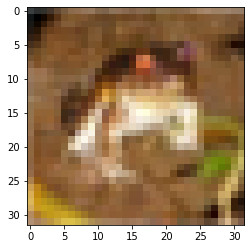

In [4]:
import matplotlib.pyplot as plt

plt.imshow(train_data_raw[0][0])

In [103]:
from torch.utils.data import Dataset
from PIL import Image

def mixup_image(img1, img2, label1, label2, lam):
    mixed_img = lam*np.asarray(img1) + (1-lam)*np.asarray(img2)
    mixed_label = lam*label1 + (1-lam)*label2
    return Image.fromarray(mixed_img.clip(0, 255).astype('uint8'), 'RGB'), mixed_label

class MixupInputDataset(Dataset):
    def __init__(self, dataset, transform=None, lam_mag=0.5, lam_random=False, lam_direction='random'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = dataset
        self.transform = transform
        self.lam_mag = lam_mag
        self.lam_random = lam_random
        self.lam_direction = lam_direction

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img, label = self.dataset[idx]
        idx2 = np.random.randint(0, len(self.dataset))
        img2, label2 = self.dataset[idx2]
        
        if self.lam_random:
            lam_mag = self.lam_mag * (0.5 + np.random.rand()/2)
        else:
            lam_mag = self.lam_mag
        
        print(lam_mag)
        
        if self.lam_direction == 'neg':
            mixed_img, mixed_label = mixup_image(img, img2, label, label2, -lam_mag)
        elif self.lam_direction == 'pos':
            mixed_img, mixed_label = mixup_image(img, img2, label, label2, 1+lam_mag)
        else:
            if np.random.rand() > 0.5:
                mixed_img, mixed_label = mixup_image(img, img2, label, label2, -lam_mag)
            else:
                mixed_img, mixed_label = mixup_image(img, img2, label, label2, 1+lam_mag)

        if self.transform:
            mixed_img = self.transform(mixed_img)

        return mixed_img, mixed_label

def mixup_input(dataset, lam_mag=0.5, lam_randomize=True):
    chosen = set()
    mixed_dataset = []
    for idx, data in enumerate(dataset):
        img = data[0]
        idx2 = np.random.randint(0, len(dataset))
        while (idx, idx2) in chosen:
            idx2 = np.random.randint(0, len(dataset))

        img2 = dataset[idx2][0]
        if lam_randomize:
            lam_mag *= np.random.rand()
        mixed1 = mixup_image(img, img2, -lam_mag)
        mixed2 = mixup_image(img, img2, 1+lam_mag)
        plt.imshow(mixed2)
        break

# mixup_input(train_data_raw)

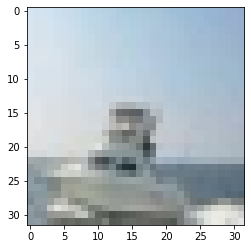

In [104]:
plt.imshow(train_data_raw[100][0])

In [150]:
cifar_mixup = MixupInputDataset(train_data_raw, lam_mag=0.9, lam_random=False, lam_direction='pos')

0.9


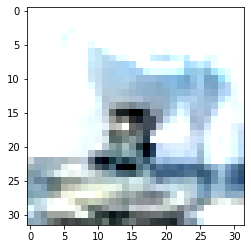

In [157]:
out = cifar_mixup[100][0]
# print(out.min(), out.max(), out.mean(), out.std())
plt.imshow(out)

In [9]:
# ood_data = TinyImages(transform=trn.Compose(
#     [trn.ToTensor(), trn.ToPILImage(), trn.RandomCrop(32, padding=4),
#      trn.RandomHorizontalFlip(), trn.ToTensor(), trn.Normalize(mean, std)]))

ood_data = MixupInputDataset(train_data_raw, lam_mag=0.5, lam_random=False, transform=train_transform)

pin = False

train_loader_in = torch.utils.data.DataLoader(
    train_data_in,
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.prefetch, pin_memory=False)

train_loader_out = torch.utils.data.DataLoader(
    ood_data,
    batch_size=args.oe_batch_size, shuffle=True, pin_memory=False)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=args.batch_size, shuffle=False,
    num_workers=args.prefetch, pin_memory=False)

In [10]:
import torchvision.models as models

# Create model
if args.model == 'resnet18':
    net = ResNet18(num_classes=10)
else:
    print("Error")

# Restore model
model_found = False
if args.load != '':
    for i in range(1000 - 1, -1, -1):
        model_name = os.path.join(args.load, args.dataset + calib_indicator + '_' + args.model +
                                  '_baseline_epoch_' + str(i) + '.pt')
        if os.path.isfile(model_name):
            net.load_state_dict(torch.load(model_name))
            print('Model restored! Epoch:', i)
            model_found = True
            break
    if not model_found:
        assert False, "could not find model to restore"

if args.ngpu > 1:
    net = torch.nn.DataParallel(net, device_ids=list(range(args.ngpu)))

if args.ngpu > 0:
    net.cuda()
    torch.cuda.manual_seed(1)

# cudnn.benchmark = True  # fire on all cylinders

optimizer = torch.optim.SGD(
    net.parameters(), state['learning_rate'], momentum=state['momentum'],
    weight_decay=state['decay'], nesterov=True)


def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (
            1 + np.cos(step / total_steps * np.pi))


scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_annealing(
        step,
        args.epochs * len(train_loader_in),
        1,  # since lr_lambda computes multiplicative factor
        1e-6 / args.learning_rate))

In [11]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

11173962

In [13]:
# /////////////// Training ///////////////

def train():
    net.train()  # enter train mode
    loss_avg = 0.0

    # start at a random point of the outlier dataset; this induces more randomness without obliterating locality
#     train_loader_out.dataset.offset = np.random.randint(len(train_loader_out.dataset))
    for in_set, out_set in tqdm(zip(train_loader_in, train_loader_out)):
        data = torch.cat((in_set[0], out_set[0]), 0)
        target = in_set[1]

        if args.ngpu > 0:
            data, target = data.cuda(), target.cuda()

        # forward
        x = net(data)

        # backward
        scheduler.step()
        optimizer.zero_grad()

        loss = F.cross_entropy(x[:len(in_set[0])], target)
        # cross-entropy from softmax distribution to uniform distribution
        loss += 0.5 * -(x[len(in_set[0]):].mean(1) - torch.logsumexp(x[len(in_set[0]):], dim=1)).mean()

        loss.backward()
        optimizer.step()

        # exponential moving average
        loss_avg = loss_avg * 0.8 + float(loss) * 0.2

    state['train_loss'] = loss_avg


# test function
def test():
    net.eval()
    loss_avg = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if args.ngpu > 0:
                data, target = data.cuda(), target.cuda()

            # forward
            output = net(data)
            loss = F.cross_entropy(output, target)

            # accuracy
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).sum().item()

            # test loss average
            loss_avg += float(loss.data)

    state['test_loss'] = loss_avg / len(test_loader)
    state['test_accuracy'] = correct / len(test_loader.dataset)


# if args.test:
#     test()
#     print(state)
#     exit()

# Make save directory
if not os.path.exists(args.save):
    os.makedirs(args.save)
if not os.path.isdir(args.save):
    raise Exception('%s is not a dir' % args.save)

with open(os.path.join(args.save, args.dataset + calib_indicator + '_' + args.model +
                                  '_oe_tune_training_results.csv'), 'w') as f:
    f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

In [14]:
args.epochs = 1

In [15]:
print('Beginning Training\n')

# Main loop
for epoch in tqdm(range(0, args.epochs)):
    state['epoch'] = epoch

    begin_epoch = time.time()

    train()
    test()

    # Save model
    torch.save(net.state_dict(),
               os.path.join(args.save, args.dataset + calib_indicator + '_' + args.model +
                            '_oe_tune_epoch_' + str(epoch) + '.pt'))
    # Let us not waste space and delete the previous model
    prev_path = os.path.join(args.save, args.dataset + calib_indicator + '_' + args.model +
                             '_oe_tune_epoch_' + str(epoch - 1) + '.pt')
    if os.path.exists(prev_path): os.remove(prev_path)

    # Show results

    with open(os.path.join(args.save, args.dataset + calib_indicator + '_' + args.model +
                                      '_oe_tune_training_results.csv'), 'a') as f:
        f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
            (epoch + 1),
            time.time() - begin_epoch,
            state['train_loss'],
            state['test_loss'],
            100 - 100. * state['test_accuracy'],
        ))

    # # print state with rounded decimals
    # print({k: round(v, 4) if isinstance(v, float) else v for k, v in state.items()})

    print('Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} | Test Error {4:.2f}'.format(
        (epoch + 1),
        int(time.time() - begin_epoch),
        state['train_loss'],
        state['test_loss'],
        100 - 100. * state['test_accuracy'])
    )

Beginning Training



  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/opt/miniconda3/envs/ood/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


KeyboardInterrupt: 

In [31]:
args.save = 'ckpts'
best_path = os.path.join(args.save, args.dataset + calib_indicator + '_' + args.model +
                            '_oe_scratch_best.pt')
checkpoint = torch.load(best_path, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [32]:
ood_test_data = dset.CIFAR100('./data', download=True, transform=test_transform, train=False)
ood_test_loader = torch.utils.data.DataLoader(
    ood_test_data,
    batch_size=args.batch_size, shuffle=False,
    num_workers=args.prefetch, pin_memory=False)

Files already downloaded and verified


In [33]:
# test function
def get_probs(loader):
    net.eval()
    scores = []
    with torch.no_grad():
        for data, target in tqdm(loader):
            if args.ngpu > 0:
                data, target = data.cuda(), target.cuda()
            output = net(data)
            score = F.softmax(output[0], dim=0)
            scores.append(score.detach().cpu().numpy())
            break
    return np.array(scores)

ood_probs = get_probs(ood_test_loader)
ood_msp = ood_probs.max(axis=1)

id_probs = get_probs(test_loader)
id_msp = id_probs.max(axis=1)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [34]:
ood_msp, id_msp

(array([0.7551151], dtype=float32), array([0.5046329], dtype=float32))

In [70]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

11689512

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve

def compute_auroc(id_pps, ood_pps, normalize=False, return_curve=False):
    y = np.concatenate((np.ones_like(ood_pps), np.zeros_like(id_pps)))
    scores = np.concatenate((ood_pps, id_pps))
    if normalize:
        scores = (scores - scores.min()) / (scores.max() - scores.min())
    if return_curve:
        return roc_curve(y, scores)
    else:
        return 100*roc_auc_score(y, scores)


In [41]:
id_msp = np.load('id_msp.npy')
ood_msp = np.load('ood_msp.npy')

oe_id_msp = np.load('oe_id_msp.npy')
oe_ood_msp = np.load('oe_ood_msp.npy')

In [45]:
compute_auroc(-id_msp, -ood_msp)

77.684196

In [46]:
compute_auroc(-oe_id_msp, -oe_ood_msp)

76.482409